In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import folium
import numpy as np
import matplotlib.pyplot as plt

##### Make a request to the website

In [2]:
res = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
res.status_code

200

##### 200 indicates success . Now extract the content from the result

In [3]:
src = res.content

In [4]:
src

b'\n<!DOCTYPE html>\n<html class="client-nojs" lang="en" dir="ltr">\n<head>\n<meta charset="UTF-8"/>\n<title>List of postal codes of Canada: M - Wikipedia</title>\n<script>document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"Xq9rzgpAICwAAKpDkkQAAADX","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_postal_codes_of_Canada:_M","wgTitle":"List of postal codes of Canada: M","wgCurRevisionId":954731857,"wgRevisionId":954731857,"wgArticleId":539066,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Articles with short description","Communications in Ontario","Postal codes in Canada","Toronto","Ontario-related 

###### Use beautiful soup to extract useful content from the code

In [5]:
soup = BeautifulSoup(src,"html.parser")

In [6]:
soup


<!DOCTYPE html>

<html class="client-nojs" dir="ltr" lang="en">
<head>
<meta charset="utf-8"/>
<title>List of postal codes of Canada: M - Wikipedia</title>
<script>document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"Xq9rzgpAICwAAKpDkkQAAADX","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_postal_codes_of_Canada:_M","wgTitle":"List of postal codes of Canada: M","wgCurRevisionId":954731857,"wgRevisionId":954731857,"wgArticleId":539066,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Articles with short description","Communications in Ontario","Postal codes in Canada","Toronto","Ontario-related lists"]

In [7]:
postal = []
borough = []
neighbor = []
table = soup.findAll('table', attrs={'class':'wikitable sortable'})
table

[<table class="wikitable sortable">
 <tbody><tr>
 <th>Postal code
 </th>
 <th>Borough
 </th>
 <th>Neighborhood
 </th></tr>
 <tr>
 <td>M1A
 </td>
 <td>Not assigned
 </td>
 <td>
 </td></tr>
 <tr>
 <td>M2A
 </td>
 <td>Not assigned
 </td>
 <td>
 </td></tr>
 <tr>
 <td>M3A
 </td>
 <td>North York
 </td>
 <td>Parkwoods
 </td></tr>
 <tr>
 <td>M4A
 </td>
 <td>North York
 </td>
 <td>Victoria Village
 </td></tr>
 <tr>
 <td>M5A
 </td>
 <td>Downtown Toronto
 </td>
 <td>Regent Park / Harbourfront
 </td></tr>
 <tr>
 <td>M6A
 </td>
 <td>North York
 </td>
 <td>Lawrence Manor / Lawrence Heights
 </td></tr>
 <tr>
 <td>M7A
 </td>
 <td>Downtown Toronto
 </td>
 <td>Queen's Park / Ontario Provincial Government
 </td></tr>
 <tr>
 <td>M8A
 </td>
 <td>Not assigned
 </td>
 <td>
 </td></tr>
 <tr>
 <td>M9A
 </td>
 <td>Etobicoke
 </td>
 <td>Islington Avenue
 </td></tr>
 <tr>
 <td>M1B
 </td>
 <td>Scarborough
 </td>
 <td>Malvern / Rouge
 </td></tr>
 <tr>
 <td>M2B
 </td>
 <td>Not assigned
 </td>
 <td>
 </td></tr>
 <tr>

###### extracting the  < tr > tags from the table

In [8]:
table_rows = table[0].find_all('tr')
table_rows = table_rows[1:]
table_rows

[<tr>
 <td>M1A
 </td>
 <td>Not assigned
 </td>
 <td>
 </td></tr>,
 <tr>
 <td>M2A
 </td>
 <td>Not assigned
 </td>
 <td>
 </td></tr>,
 <tr>
 <td>M3A
 </td>
 <td>North York
 </td>
 <td>Parkwoods
 </td></tr>,
 <tr>
 <td>M4A
 </td>
 <td>North York
 </td>
 <td>Victoria Village
 </td></tr>,
 <tr>
 <td>M5A
 </td>
 <td>Downtown Toronto
 </td>
 <td>Regent Park / Harbourfront
 </td></tr>,
 <tr>
 <td>M6A
 </td>
 <td>North York
 </td>
 <td>Lawrence Manor / Lawrence Heights
 </td></tr>,
 <tr>
 <td>M7A
 </td>
 <td>Downtown Toronto
 </td>
 <td>Queen's Park / Ontario Provincial Government
 </td></tr>,
 <tr>
 <td>M8A
 </td>
 <td>Not assigned
 </td>
 <td>
 </td></tr>,
 <tr>
 <td>M9A
 </td>
 <td>Etobicoke
 </td>
 <td>Islington Avenue
 </td></tr>,
 <tr>
 <td>M1B
 </td>
 <td>Scarborough
 </td>
 <td>Malvern / Rouge
 </td></tr>,
 <tr>
 <td>M2B
 </td>
 <td>Not assigned
 </td>
 <td>
 </td></tr>,
 <tr>
 <td>M3B
 </td>
 <td>North York
 </td>
 <td>Don Mills
 </td></tr>,
 <tr>
 <td>M4B
 </td>
 <td>East York
 </td>


###### Extract < td > tag from each row and place it in it's respective group

In [9]:
for a in table_rows:
    td = a.find_all('td')
    postal.append(td[0].text[:-1])
    borough.append(td[1].text[:-1])
    neighbor.append(td[2].text[:-1])

In [10]:
borough

['Not assigned',
 'Not assigned',
 'North York',
 'North York',
 'Downtown Toronto',
 'North York',
 'Downtown Toronto',
 'Not assigned',
 'Etobicoke',
 'Scarborough',
 'Not assigned',
 'North York',
 'East York',
 'Downtown Toronto',
 'North York',
 'Not assigned',
 'Not assigned',
 'Etobicoke',
 'Scarborough',
 'Not assigned',
 'North York',
 'East York',
 'Downtown Toronto',
 'York',
 'Not assigned',
 'Not assigned',
 'Etobicoke',
 'Scarborough',
 'Not assigned',
 'Not assigned',
 'East Toronto',
 'Downtown Toronto',
 'York',
 'Not assigned',
 'Not assigned',
 'Not assigned',
 'Scarborough',
 'Not assigned',
 'Not assigned',
 'East York',
 'Downtown Toronto',
 'Downtown Toronto',
 'Not assigned',
 'Not assigned',
 'Not assigned',
 'Scarborough',
 'North York',
 'North York',
 'East York',
 'Downtown Toronto',
 'West Toronto',
 'Not assigned',
 'Not assigned',
 'Not assigned',
 'Scarborough',
 'North York',
 'North York',
 'East York',
 'Downtown Toronto',
 'West Toronto',
 'Not assi

In [11]:
neighbor

['',
 '',
 'Parkwoods',
 'Victoria Village',
 'Regent Park / Harbourfront',
 'Lawrence Manor / Lawrence Heights',
 "Queen's Park / Ontario Provincial Government",
 '',
 'Islington Avenue',
 'Malvern / Rouge',
 '',
 'Don Mills',
 'Parkview Hill / Woodbine Gardens',
 'Garden District / Ryerson',
 'Glencairn',
 '',
 '',
 'West Deane Park / Princess Gardens / Martin Grove / Islington / Cloverdale',
 'Rouge Hill / Port Union / Highland Creek',
 '',
 'Don Mills',
 'Woodbine Heights',
 'St. James Town',
 'Humewood-Cedarvale',
 '',
 '',
 'Eringate / Bloordale Gardens / Old Burnhamthorpe / Markland Wood',
 'Guildwood / Morningside / West Hill',
 '',
 '',
 'The Beaches',
 'Berczy Park',
 'Caledonia-Fairbanks',
 '',
 '',
 '',
 'Woburn',
 '',
 '',
 'Leaside',
 'Central Bay Street',
 'Christie',
 '',
 '',
 '',
 'Cedarbrae',
 'Hillcrest Village',
 'Bathurst Manor / Wilson Heights / Downsview North',
 'Thorncliffe Park',
 'Richmond / Adelaide / King',
 'Dufferin / Dovercourt Village',
 '',
 '',
 '',


In [12]:
postal

['M1A',
 'M2A',
 'M3A',
 'M4A',
 'M5A',
 'M6A',
 'M7A',
 'M8A',
 'M9A',
 'M1B',
 'M2B',
 'M3B',
 'M4B',
 'M5B',
 'M6B',
 'M7B',
 'M8B',
 'M9B',
 'M1C',
 'M2C',
 'M3C',
 'M4C',
 'M5C',
 'M6C',
 'M7C',
 'M8C',
 'M9C',
 'M1E',
 'M2E',
 'M3E',
 'M4E',
 'M5E',
 'M6E',
 'M7E',
 'M8E',
 'M9E',
 'M1G',
 'M2G',
 'M3G',
 'M4G',
 'M5G',
 'M6G',
 'M7G',
 'M8G',
 'M9G',
 'M1H',
 'M2H',
 'M3H',
 'M4H',
 'M5H',
 'M6H',
 'M7H',
 'M8H',
 'M9H',
 'M1J',
 'M2J',
 'M3J',
 'M4J',
 'M5J',
 'M6J',
 'M7J',
 'M8J',
 'M9J',
 'M1K',
 'M2K',
 'M3K',
 'M4K',
 'M5K',
 'M6K',
 'M7K',
 'M8K',
 'M9K',
 'M1L',
 'M2L',
 'M3L',
 'M4L',
 'M5L',
 'M6L',
 'M7L',
 'M8L',
 'M9L',
 'M1M',
 'M2M',
 'M3M',
 'M4M',
 'M5M',
 'M6M',
 'M7M',
 'M8M',
 'M9M',
 'M1N',
 'M2N',
 'M3N',
 'M4N',
 'M5N',
 'M6N',
 'M7N',
 'M8N',
 'M9N',
 'M1P',
 'M2P',
 'M3P',
 'M4P',
 'M5P',
 'M6P',
 'M7P',
 'M8P',
 'M9P',
 'M1R',
 'M2R',
 'M3R',
 'M4R',
 'M5R',
 'M6R',
 'M7R',
 'M8R',
 'M9R',
 'M1S',
 'M2S',
 'M3S',
 'M4S',
 'M5S',
 'M6S',
 'M7S',
 'M8S',


###### Create a data frame

In [13]:
df = pd.DataFrame({'PostalCode':postal,'Boroughs':borough,'Neighbourhood':neighbor})

In [14]:
df.head()

,PostalCode,Boroughs,Neighbourhood
0,M1A,Not assigned,
1,M2A,Not assigned,
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront


###### Remove rows where Boroughs = ' Not assigned'

In [15]:
df = df.loc[df["Boroughs"]!='Not assigned']
df

,PostalCode,Boroughs,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront
5,M6A,North York,Lawrence Manor / Lawrence Heights
6,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government
...,...,...,...
160,M8X,Etobicoke,The Kingsway / Montgomery Road / Old Mill North
165,M4Y,Downtown Toronto,Church and Wellesley
168,M7Y,East Toronto,Business reply mail Processing Centre
169,M8Y,Etobicoke,Old Mill South / King's Mill Park / Sunnylea /...


###### Checing for rows with the same postal code

In [16]:
pcode = df["PostalCode"].unique()
len(pcode)

103

In [17]:
# from the above we can see 103 unique vales of postal code for 103 rows , so every row has a unique postal code

In [18]:
df.loc[df["Neighbourhood"] == 'Not assigned']

,PostalCode,Boroughs,Neighbourhood


In [19]:
print("Number of rows is",df.shape[0])

Number of rows is 103


In [20]:
pc = pd.read_csv("postal_code.csv")
pc.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [21]:
latitude = []
longitude = []
for i in range(df.shape[0]):
    p = df.iloc[i,0]
    latitude.append(pc.loc[pc["Postal Code"] == p,"Latitude"].values[0])
    longitude.append(pc.loc[pc["Postal Code"] == p,"Longitude"].values[0])

In [22]:
df["Latitude"] = latitude
df["Longitude"] = longitude

In [23]:
df.head(10)

,PostalCode,Boroughs,Neighbourhood,Latitude,Longitude
2,M3A,North York,Parkwoods,43.753259,-79.329656
3,M4A,North York,Victoria Village,43.725882,-79.315572
4,M5A,Downtown Toronto,Regent Park / Harbourfront,43.654260,-79.360636
5,M6A,North York,Lawrence Manor / Lawrence Heights,43.718518,-79.464763
6,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government,43.662301,-79.389494
8,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
9,M1B,Scarborough,Malvern / Rouge,43.806686,-79.194353
11,M3B,North York,Don Mills,43.745906,-79.352188
12,M4B,East York,Parkview Hill / Woodbine Gardens,43.706397,-79.309937
13,M5B,Downtown Toronto,Garden District / Ryerson,43.657162,-79.378937


###### Generate a map of Toronto

In [24]:
map = folium.Map(location=[43.7, -79.4], zoom_start=10)

In [25]:
map

In [26]:
for lat, lng, borough, neighborhood in zip(df["Latitude"], df["Longitude"], df["Boroughs"], df["Neighbourhood"]):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)  
    
map

In [27]:
from sklearn.cluster import KMeans
# set number of clusters
kclusters_array = [1,2,3,4,5,6,7,8,9,10]
inertia = []
for kclusters in kclusters_array:
    toronto_grouped_clustering = df.drop(columns = ["PostalCode","Boroughs","Neighbourhood"])
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)
    inertia.append(kmeans.inertia_)

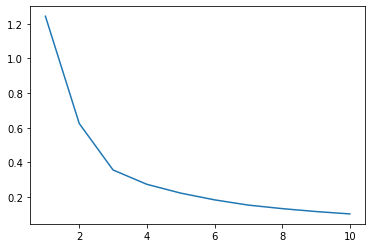

In [28]:
plt.plot(kclusters_array,inertia)

In [29]:
#using the elbow method we can see the right number of clusters are 3

In [30]:
toronto_grouped_clustering = df.drop(columns = ["PostalCode","Boroughs","Neighbourhood"])
kmeans = KMeans(n_clusters=3, random_state=0).fit(toronto_grouped_clustering)

In [31]:
# create map
map_clusters = folium.Map(location=[43.7, -79.4], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
rainbow = ["red","blue","orange"]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df['Latitude'], df['Longitude'], df['Neighbourhood'], kmeans.labels_):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters